In [57]:
import emcee
import corner
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [299]:
class TimeSeries():
    def __init__(self, time=None, size=1000, sampling_rate=1):
        '''
        Input
            time    (ndarray (n,))     time array
            size    (scalar)           size of time array
        '''

        # true values used to generate the time series
        # [sigma, log(h0), log(f), phi]
        self.truths = [0, 0, 0, 0]

        if time == None:
            self.time = np.arange(0, sampling_rate * size, sampling_rate)
        else:
            self.time = time
        
        self.generate_noise()

    def generate_noise(self):
        '''
        Generate white noise
        Input
            sigma (scalar):     noise parameter <n_I n_J> = delta_{IJ}
        '''
        self.noise = np.random.normal(size=len(self.time))
        self.series = self.noise
        self.truths[0] = 1
    
    def generate_coherent_signal(self, amp:float, f: float, phi:float):
        '''
        Generate coherent signal
        Input
            f   (scalar):   frequency [Hz]
            phi (scalar):   phase
        '''
        self.signal = amp * np.cos(2 * np.pi * f * self.time + phi)
        self.series += self.signal
        self.truths[1] = np.log(amp)
        self.truths[2] = np.log(f)
        self.truths[3] = phi

    def plot(self):
        plt.plot(self.series)
        plt.plot(self.signal)


In [291]:
def log_likelihood(theta, x, y):
    '''
    Log-lilkelihood function
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
        x     (ndarray (n,))        time stamp
        y     (ndarray (n,))        time series
    '''

    sigma, ln_h0, ln_f, phi = theta
    model = np.exp(ln_h0) * np.cos(2 * np.pi * np.exp(ln_f) * x + phi)
    return -0.5 * np.sum((y - model)**2 / sigma**2 + np.log(sigma**2))

def log_prior(theta):
    '''
    Log prior function; uniform prior is chosen
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
    '''
    sigma, ln_h0, ln_f, phi = theta
    if (0.1 <= sigma <= 5.0 
        and -5.0 <= ln_h0 <= 0.0
        and -5.0 <= ln_f <= 0
        and 0 <= phi < 2 * np.pi):
        return 0.0
    else:
        return -np.inf
    
def log_prob(theta, x, y):
    '''
    Log posterior function
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
        x     (ndarray (n,))        time stamp
        y     (ndarray (n,))        time series
    '''
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, x, y)

def draw_initial(nwalker):
    sigma = np.random.uniform(0.1, 5.0, nwalker)
    ln_h0 = np.random.uniform(-5.0, 0.0, nwalker)
    ln_f = np.random.uniform(-5.0, 0.0, nwalker)
    phi = np.random.uniform(0, 2 * np.pi, nwalker)

    return np.vstack((sigma, ln_h0, ln_f, phi)).T

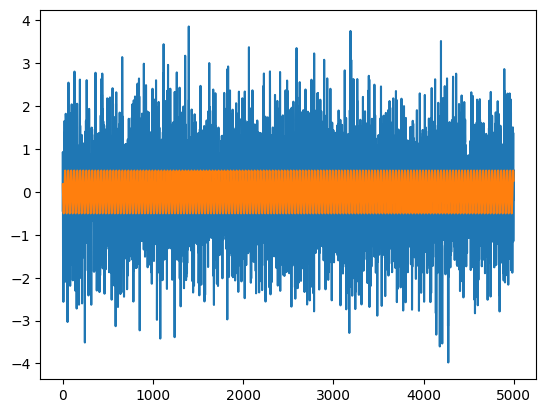

In [301]:
my = TimeSeries(size=5000)
my.generate_coherent_signal(0.5, 0.03, 1.2)
my.plot()

In [294]:
coords = draw_initial(32)
nwalkers, ndim = coords.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(my.time, my.series))

In [295]:
sampler.run_mcmc(coords, 500000, progress=True);

100%|██████████| 500000/500000 [08:32<00:00, 976.08it/s]


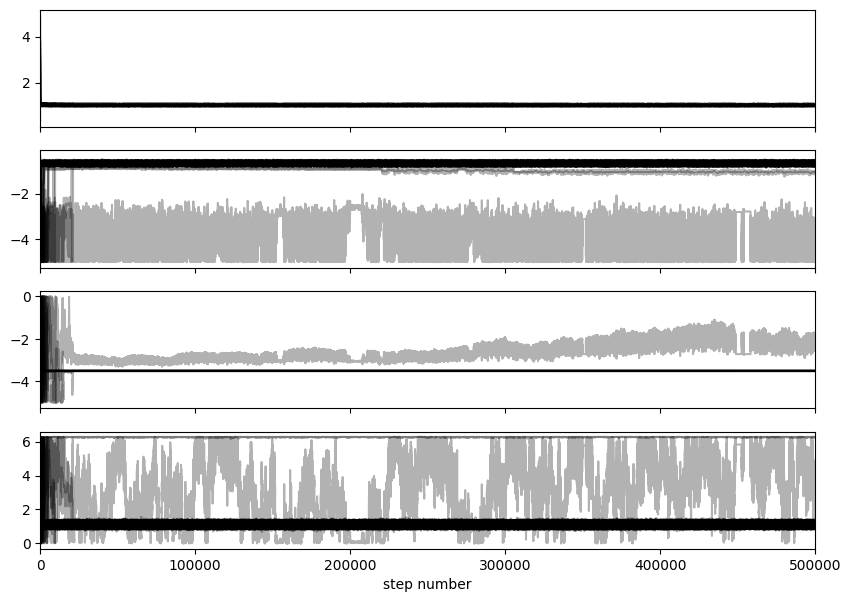

In [296]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [305]:
flat_samples = sampler.get_chain(discard=100000, thin=15, flat=True)

In [283]:
my_sample = np.concatenate(samples[20000:,:10, :3], axis=0)

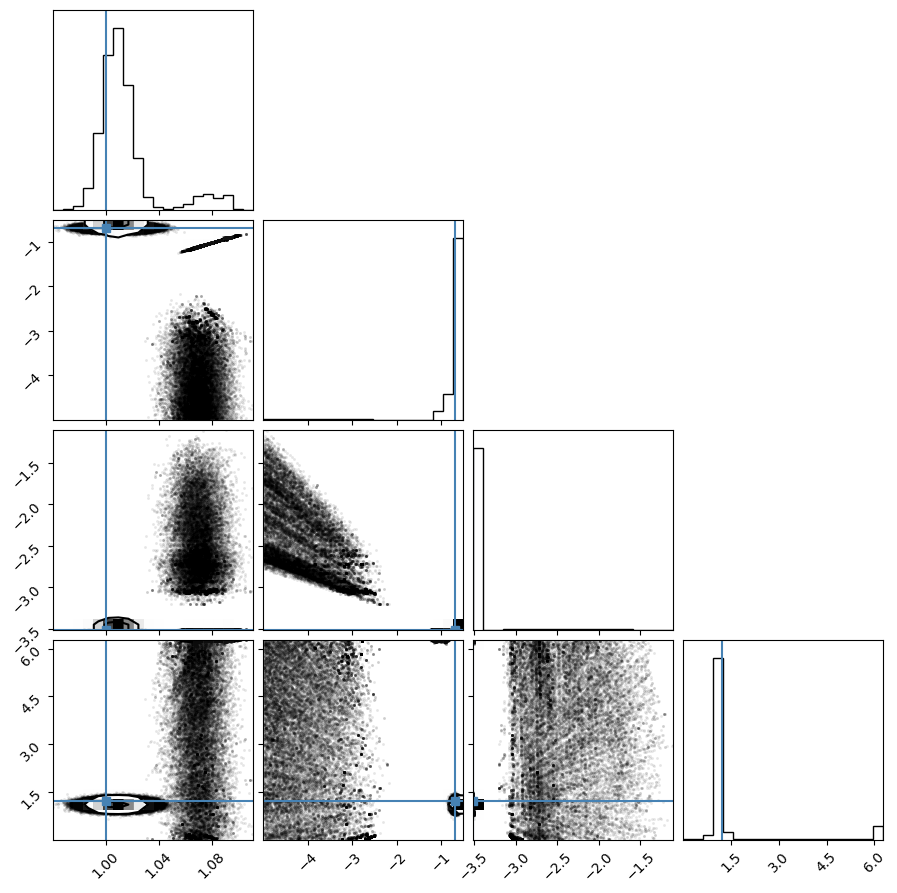

In [306]:
fig = corner.corner(flat_samples,
                    truths=my.truths);

# fig = corner.corner(my_sample);
# fig = corner.corner(samples[10000:,1, :3])

In [308]:
(77 - 41) / (99 - 41)

0.6206896551724138